In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


C:\Users\satellite\AppData\Local\Temp\ipykernel_3024\2447351786.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satellite\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
data = pd.read_csv('spam.csv')
data.head()

,Category,Message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.shape

(5572, 2)

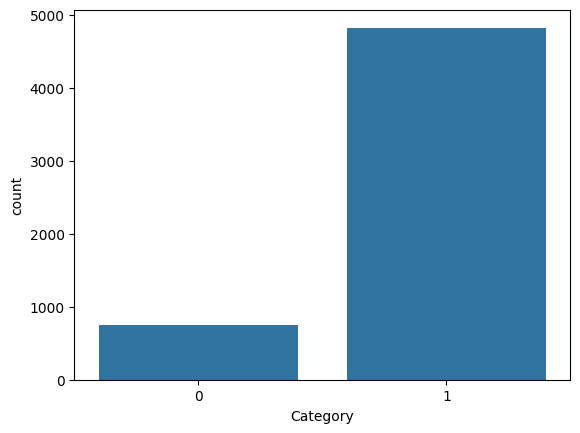

In [28]:
 
sns.countplot(x='Category', data=data)
plt.show()

1494


Text(0.5, 0, 'Message types')

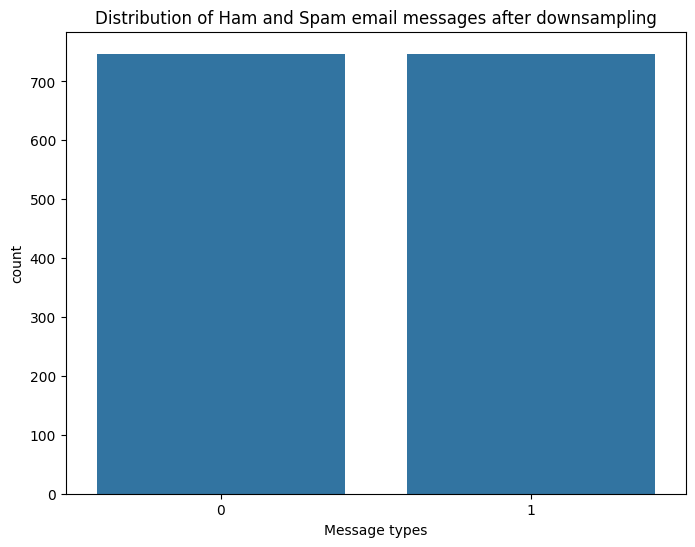

In [37]:
ham_msg = data[data.Category == 0]
spam_msg = data[data.Category == 1]


# Ensure that the sample size does not exceed the available number of ham messages
sample_size = min(len(ham_msg), len(spam_msg))

spam_msg = spam_msg.sample(n=len(ham_msg),
                         random_state=42)
# Plotting the counts of the downsampled dataset
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
print(len(balanced_data))
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='Category')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [39]:
balanced_data.head()

,Category,Message
0,0,Free entry in 2 a wkly comp to win FA Cup fina...
1,0,FreeMsg Hey there darling it's been 3 week's n...
2,0,WINNER!! As a valued network customer you have...
3,0,Had your mobile 11 months or more? U R entitle...
4,0,"SIX chances to win CASH! From 100 to 20,000 po..."


In [40]:
balanced_data['Message'] = balanced_data['Message'].str.replace('Subject', '')
balanced_data.head()

,Category,Message
0,0,Free entry in 2 a wkly comp to win FA Cup fina...
1,0,FreeMsg Hey there darling it's been 3 week's n...
2,0,WINNER!! As a valued network customer you have...
3,0,Had your mobile 11 months or more? U R entitle...
4,0,"SIX chances to win CASH! From 100 to 20,000 po..."


In [41]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['Message']= balanced_data['Message'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,Category,Message
0,0,Free entry in 2 a wkly comp to win FA Cup fina...
1,0,FreeMsg Hey there darling its been 3 weeks now...
2,0,WINNER As a valued network customer you have b...
3,0,Had your mobile 11 months or more U R entitled...
4,0,SIX chances to win CASH From 100 to 20000 poun...


In [42]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['Message'] = balanced_data['Message'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Category,Message
0,0,free entry 2 wkly comp win fa cup final tkts 2...
1,0,freemsg hey darling 3 weeks word back id like ...
2,0,winner valued network customer selected receiv...
3,0,mobile 11 months u r entitled update latest co...
4,0,six chances win cash 100 20000 pounds txt csh1...


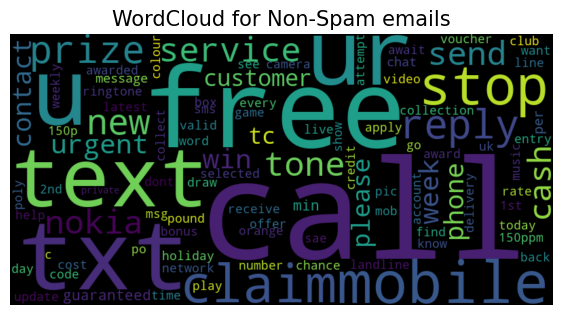

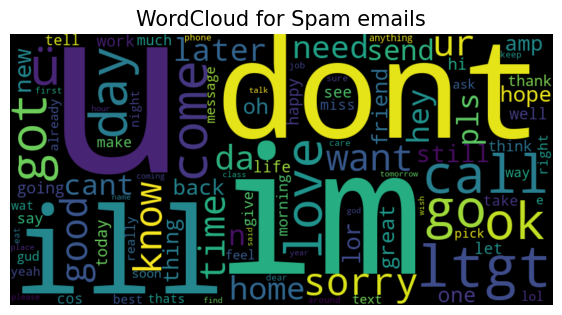

In [44]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['Message'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['Category'] == 0], typ='Spam')
plot_word_cloud(balanced_data[balanced_data['Category'] == 1], typ='Non-Spam')


In [45]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Message'],
													balanced_data['Category'],
													test_size = 0.2,
													random_state = 42)


In [46]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len, 
								padding='post', 
								truncating='post')
test_sequences = pad_sequences(test_sequences, 
							maxlen=max_len, 
							padding='post', 
							truncating='post')


In [47]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32, 
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           131680    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 135393 (528.88 KB)
Trainable params: 135393 (528.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [60]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.4,
					verbose = 0)


In [61]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=20, 
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
38/38 [==============================] - 1s 20ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.4849 - lr: 2.2500e-04
Epoch 2/20
38/38 [==============================] - 1s 20ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.4849 - lr: 2.2500e-04
Epoch 3/20
38/38 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.4921 - val_loss: 0.6932 - val_accuracy: 0.4849 - lr: 2.2500e-04
Epoch 4/20
38/38 [==============================] - 1s 20ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4849 - lr: 2.2500e-04


In [57]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


10/10 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.4849
Test Loss : 0.6934462785720825
Test Accuracy : 0.48494982719421387


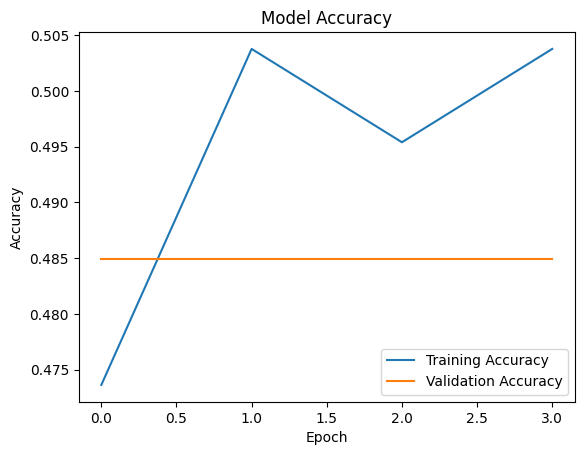

In [54]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
